In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random, os, pathlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

## 2D dataset
### Binary classification

In [2]:
import mylibrary.nnlib as tnn

In [3]:
#http://notmatthancock.github.io/software/dataset2d/

# data_path = "./data/noisy_moon_2d_2c.csv"
data_path = "./data/noisy_linear_2d_2c.csv"
# data_path = "./data/clean_circular_2d_2c.csv"


df = pd.read_csv(data_path)
# print(df.columns)
x1 = np.array(df['# x'], dtype=float)/200
x2 = np.array(df['y'], dtype=float)/200
y = np.array(df['label'], dtype=int)

In [4]:
def twospirals(n_points, noise=.5 , ang=720):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * ang * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

np.random.seed(1234)
# x, y = twospirals(200, ang=420)
x, y = twospirals(200, ang=400)
x, y = x/10, y.reshape(-1)
x1, x2 = x[:,0], x[:,1]

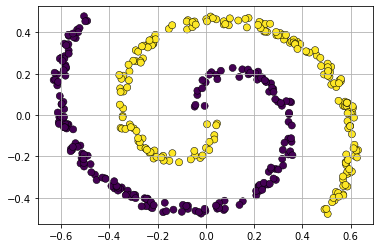

In [5]:
%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)
plt.grid()

In [6]:
xx = np.column_stack((x1, x2))
inp = torch.tensor(xx, dtype=torch.float32)
yy = torch.tensor(y, dtype=torch.float32).reshape(-1,1)

In [7]:
## for db image plotting
n = 200
x_, y_ = np.meshgrid(np.linspace(xx[:,0].min(), xx[:,0].max(), n), np.linspace(xx[:,1].min(), xx[:,1].max(), n))
xx_img = np.c_[x_.ravel(), y_.ravel()]
xx_img = torch.FloatTensor(xx_img)

v = np.linspace(0.0, 1.0, 11, endpoint=True)

In [8]:
class BCE_MSE_Loss(nn.Module):
    
    def __init__(self, bce_beta=1):
        super().__init__()
        assert bce_beta >= 0 and bce_beta <= 1
        
        self.bce_beta = bce_beta
    
    def forward(self, output, target):
        bce = F.binary_cross_entropy(output, target)
        mse = 0.5*((output-target)**2).sum()
        
        return self.bce_beta*bce + (1-self.bce_beta)*mse*4

In [9]:
network_seed = 258 # 147 # 369

# Logistic Regression

In [10]:
class LogisticRegression(nn.Module):
    
    def __init__(self, dim=784):
        super().__init__()
        self.linear = nn.Linear(dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.sigmoid(self.linear(x))
        return x

In [11]:
torch.manual_seed(network_seed)
logNet = LogisticRegression(2)
optimizer = torch.optim.Adam(logNet.parameters(), lr=0.01)
# criterion = nn.BCELoss()
criterion = BCE_MSE_Loss()

In [12]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(10000):
    yout = logNet(inp)    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, Norm: {float(torch.norm(logNet.linear.weight.data))}')
        ax.clear()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.')
        
        yout_img = logNet(xx_img)
        # out = (yout_img.data.numpy()>0.5).astype(int)
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape), v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
#         cbar = fig.colorbar(cf)
        ax.grid()

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:132.7245330810547, Acc:71.75, Norm: 0.30709022283554077


Epoch: 100, Loss:108.77888488769531, Acc:72.0, Norm: 1.5639324188232422


Epoch: 200, Loss:100.98053741455078, Acc:72.0, Norm: 2.395125389099121


Epoch: 300, Loss:98.68699645996094, Acc:72.0, Norm: 2.9020471572875977


Epoch: 400, Loss:98.02043151855469, Acc:72.0, Norm: 3.20294189453125


Epoch: 500, Loss:97.83306121826172, Acc:72.0, Norm: 3.375554084777832


Epoch: 600, Loss:97.78418731689453, Acc:72.0, Norm: 3.4696810245513916


Epoch: 700, Loss:97.77279663085938, Acc:72.0, Norm: 3.5177414417266846


Epoch: 800, Loss:97.7704849243164, Acc:72.0, Norm: 3.5404443740844727


Epoch: 900, Loss:97.77008819580078, Acc:72.0, Norm: 3.550274610519409


Epoch: 1000, Loss:97.77002716064453, Acc:72.0, Norm: 3.554150104522705


Epoch: 1100, Loss:97.77001953125, Acc:72.0, Norm: 3.555532455444336


Epoch: 1200, Loss:97.77001953125, Acc:72.0, Norm: 3.555976629257202


Epoch: 1300, Loss:97.77001953125, Acc:72.0, Norm: 3.556104898

TclError: invalid command name "pyimage14"

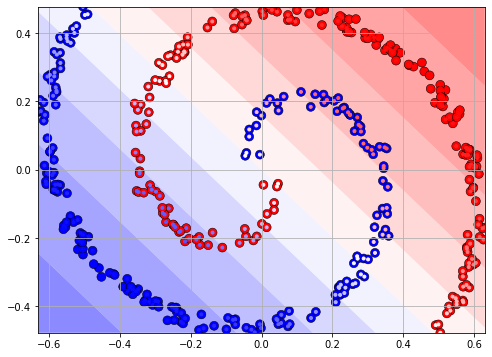

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

# Bandpass Regression

In [14]:
class Bandpass(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        ##mean, var, a
        self.mean = nn.Parameter(torch.randn(1,input_dim, dtype=torch.float32))
        self.icov = nn.Parameter(torch.eye(input_dim, input_dim, dtype=torch.float32)*2)
        self.a = nn.Parameter(torch.tensor([2], dtype=torch.float32))
        
    def forward(self, x):
        self.a.data = torch.clamp(self.a.data, 0.01, 100)
#         self.a.data = torch.clamp(self.a.data, -100, 100)
        x = x-self.mean
        xm = torch.matmul(x.unsqueeze(1), self.icov)
        xm = torch.matmul(xm, x.unsqueeze(2)).squeeze(1)
        xm = torch.abs(xm)
        xm = torch.exp(-(xm**self.a))
        return xm

In [15]:
torch.manual_seed(network_seed)
bpNet = Bandpass(2)
optimizer = torch.optim.Adam(bpNet.parameters(), lr=0.01)
# criterion = nn.BCELoss()
criterion = BCE_MSE_Loss()

In [16]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(10000):
    yout = bpNet(inp)    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, A: {float(bpNet.a.data[0])}')
        ax.clear()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.')
        
        yout_img = bpNet(xx_img)
        # out = (yout_img.data.numpy()>0.5).astype(int)
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape), v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:248.51622009277344, Acc:47.25, A: 1.9900000095367432


Epoch: 100, Loss:105.24227905273438, Acc:71.75, A: 1.1386469602584839


Epoch: 200, Loss:94.64276123046875, Acc:72.25, A: 0.6667773127555847


Epoch: 300, Loss:92.95748138427734, Acc:72.75, A: 0.6649701595306396


Epoch: 400, Loss:91.36888885498047, Acc:73.25, A: 0.640864908695221


Epoch: 500, Loss:88.5329360961914, Acc:73.5, A: 0.5507219433784485


Epoch: 600, Loss:87.23764038085938, Acc:74.5, A: 0.5400370955467224


Epoch: 700, Loss:86.93479919433594, Acc:74.5, A: 0.5461216568946838


Epoch: 800, Loss:86.84860229492188, Acc:74.25, A: 0.5532026886940002


Epoch: 900, Loss:86.81774139404297, Acc:74.5, A: 0.5547309517860413


Epoch: 1000, Loss:86.81410217285156, Acc:74.5, A: 0.5555984377861023


Epoch: 1100, Loss:86.81399536132812, Acc:74.5, A: 0.5557506680488586


Epoch: 1200, Loss:86.81393432617188, Acc:74.5, A: 0.5557329058647156


Epoch: 1300, Loss:86.8150634765625, Acc:74.5, A: 0.5556715726852417


Epoch: 1400, 

TclError: invalid command name "pyimage29"

In [17]:
bpNet.a.data

tensor([0.5558])

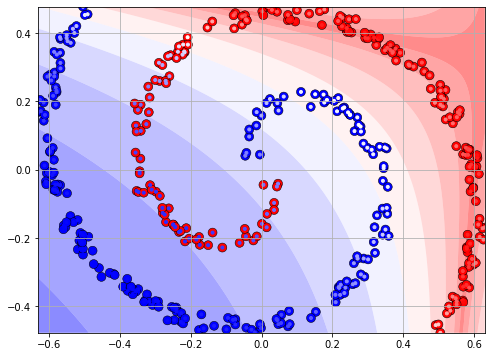

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

# Convex NN

In [19]:
class ConvexNN(nn.Module):
    
    def __init__(self, dims:list, actf=nn.ELU):
        super().__init__()
        assert len(dims)>1
        self.dims = dims
        layers = []
        skip_layers = []
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i<len(dims)-2:
                layers.append(actf())
            if i>0:
                skip_layers.append(nn.Linear(dims[0], dims[i+1]))
                
        self.layers = nn.ModuleList(layers)
        self.skip_layers = nn.ModuleList(skip_layers)
#         print(layers)
#         print(skip_layers)
        
    def forward(self,x):
        h = x
        for i in range(len(self.dims)-1):
#             print(i)
#             print(self.layers[i*2])
            self.layers[i*2].weight.data = torch.abs(self.layers[i*2].weight.data)
            h = self.layers[i*2](h)
            if i>0:
                h += self.skip_layers[i-1](x)
            if i<len(self.dims)-2:
                h = self.layers[i*2+1](h)
        return h

In [20]:
# cvxNet = ConvexNN([2, 10, 10, 1])
# cvxNet(inp)
# list(cvxNet.parameters())

In [21]:
torch.manual_seed(network_seed)
# actf = nn.LeakyReLU
actf = nn.ELU
cvxNet = ConvexNN([2,100,100,1], actf)
sigmoid = nn.Sigmoid()

optimizer = torch.optim.Adam(cvxNet.parameters(), lr=0.01)
# criterion = nn.BCELoss()
criterion = BCE_MSE_Loss()

In [22]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(10000):
    yout = sigmoid(-cvxNet(inp))    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}')
        ax.clear()
        yout_img = sigmoid(-cvxNet(xx_img))
        # out = (yout_img.data.numpy()>0.5).astype(int)
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:333.1568908691406, Acc:29.0


Epoch: 100, Loss:97.42655181884766, Acc:72.5


Epoch: 200, Loss:90.8792724609375, Acc:74.25


Epoch: 300, Loss:83.60576629638672, Acc:80.25


Epoch: 400, Loss:80.01727294921875, Acc:82.0


Epoch: 500, Loss:77.05062103271484, Acc:83.0


Epoch: 600, Loss:78.36420440673828, Acc:82.0


Epoch: 700, Loss:75.40441131591797, Acc:82.25


Epoch: 800, Loss:73.68241119384766, Acc:83.0


Epoch: 900, Loss:73.87499237060547, Acc:83.0


Epoch: 1000, Loss:73.1008529663086, Acc:82.25


Epoch: 1100, Loss:73.911865234375, Acc:83.25


Epoch: 1200, Loss:72.26803588867188, Acc:82.5


Epoch: 1300, Loss:72.13082122802734, Acc:82.5


Epoch: 1400, Loss:74.90008544921875, Acc:82.25


Epoch: 1500, Loss:71.97935485839844, Acc:82.25


Epoch: 1600, Loss:75.53619384765625, Acc:80.75


Epoch: 1700, Loss:71.59916687011719, Acc:82.5


Epoch: 1800, Loss:71.86100006103516, Acc:82.25


Epoch: 1900, Loss:71.40107727050781, Acc:82.5


Epoch: 2000, Loss:73.29691314697266, Acc:82.0



TclError: invalid command name "pyimage43"

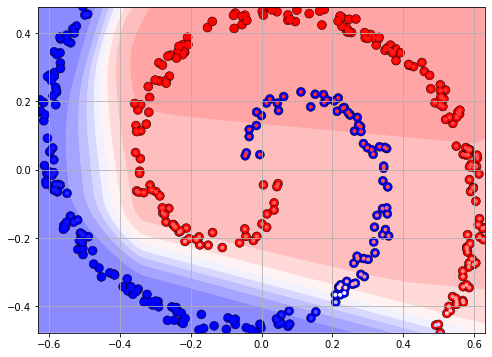

In [23]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

# Invex

In [10]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

In [10]:
class BasicInvexNet(nn.Module):
    
    def __init__(self, input_dim, net, lamda=1.):
        super().__init__()
        
        self.net = net
        self.center = nn.Parameter(torch.zeros(input_dim).unsqueeze(0))
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx_cent = None
        self.dydx = None
        
        self.gp = 0
        self.gclipper = 999
        
    def forward(self, x, hook=True):
#         self.weight_norm()
        self.X = x
        if not x.requires_grad:
            self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        if y.requires_grad and hook:
            y.register_hook(self.scale_gradient_back)
        return y
    
    def scale_gradient_back(self, grad):
        return torch.minimum(torch.maximum(grad, -self.gclipper), self.gclipper)
    
    def weight_norm(self):
        for child in get_children(self.net):
            if isinstance(child, nn.Linear):
                norm = torch.norm(child.weight.data, dim=1)
#                 print(norm)
                indx = torch.nonzero(norm>5., as_tuple=False).t()[0]
                if len(indx)==0: continue
#                 print(indx)
#                 print("Weight")
#                 print(child.weight.data[indx].shape)
                child.weight.data[indx] *= 3/(norm[indx].reshape(-1,1))
        
    def get_dydx_cent(self):
        self.dydx_cent = self.center-self.X.data
        self.dydx_cent = self.dydx_cent/torch.norm(self.dydx_cent, p=2, dim=1, keepdim=True)
        return self.dydx_cent
    
    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def smooth_l1(self, x, beta=1):
        mask = x<beta
        y = torch.empty_like(x)
        y[mask] = 0.5*(x[mask]**2)/beta
        y[~mask] = torch.abs(x[~mask])-0.5*beta
        return y
    
    def get_gradient_penalty(self):
        m = self.dydx.shape[0]
        ## gradient is projected in the direction of center (aka. minima/maxima)
        projected_grad = torch.bmm(self.dydx.view(m, 1, -1), self.dydx_cent.view(m, -1, 1)).view(-1, 1)
        self.cond = projected_grad
        
        a=-20
#         intolerables = torch.log(torch.exp(a*(self.cond-0.1))+1)/a
#         intolerables = torch.clamp(F.softplus(self.cond-0.1, beta=-20), -1, 1)
        intolerables = F.softplus(self.cond-0.1, beta=-20)

#         dydx_norm = torch.norm(self.dydx.data, p=2, dim=1, keepdim=True)
#         self.gp = 0.5*((intolerables*5)**2).mean()*self.lamda
        
        self.gp = (self.smooth_l1(intolerables*5)).mean()*self.lamda

        return self.gp
    
    def get_gradient_clipper(self):
        with torch.no_grad():
            cond = self.cond.data
            linear_mask = cond>0.14845
            a = 20.
            gclipper = -((1.05*(cond-1))**4)+1
            gclipper = torch.log(torch.exp(a*gclipper)+1)/a
            gc2 = 3*cond-0.0844560006
            gclipper[linear_mask] = gc2[linear_mask]
            self.gclipper = gclipper
        return self.gclipper

    def MSE_loss(self, diff):
        return 0.5*(diff**2).mean()
    
    def compute_penalty_and_clipper(self):
        self.get_dydx_cent()
        self.get_dydx()
        self.get_gradient_penalty()
        self.get_gradient_clipper()
        return

In [11]:
torch.manual_seed(network_seed)
actf = nn.LeakyReLU
# actf = nn.ELU # nn.Softplus
net_lips = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
#                          nn.Sigmoid(),
                        )
sigmoid = nn.Sigmoid()
# sigmoid = lambda x: x

lcNet = BasicInvexNet(2, net_lips, lamda=1.5)

optimizer = torch.optim.Adam(lcNet.parameters(), lr=0.01)
# criterion = nn.BCELoss()
criterion = BCE_MSE_Loss()

In [12]:
# __x = torch.linspace(-2,2)
# %matplotlib inline
# plt.plot(__x.numpy(), nn.Softplus(-10)(__x).numpy())

In [28]:
# torch.norm(get_children(net_lips)[0].weight.data, dim=1, keepdim=True)>3
# lcNet(inp)

In [29]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(50000):
    yout = sigmoid(lcNet(inp))    
    lcNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + lcNet.gp
    if float(lcNet.gp)>1:
        print("!!!!!!!!!!!!!!!", lcNet.gp)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(lcNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(lcNet(xx_img))
        # out = (yout_img.data.numpy()>0.5).astype(int)
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:140.289306640625, Acc:50.0, MinVal:-0.10520028322935104, gp: 0.4131729304790497


!!!!!!!!!!!!!!! tensor(1.7017, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.3410, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.6948, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.8273, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.6301, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.8197, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.6641, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.6742, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(3.1570, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(3.0745, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.6269, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.2290, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.8720, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.7540, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.9971, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.9684, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(



Epoch: 300, Loss:17.55544662475586, Acc:96.5, MinVal:-1.1931686401367188, gp: 0.30821001529693604


!!!!!!!!!!!!!!! tensor(1.0772, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.4658, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.5310, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(2.0805, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.5509, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.0294, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.3208, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.3990, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.0134, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.1133, grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!! tensor(1.3473, grad_fn=<MulBackward0>)
Epoch: 400, Loss:13.810550689697266, Acc:96.0, MinVal:-1.082381010055542, gp: 0.3515940010547638


Epoch: 500, Loss:12.866920471191406, Acc:96.75, MinVal:-1.1636199951171875, gp: 0.21783190965652466


Epoch: 600, Loss:15.850828170776367, Acc:96.5, MinVal:-0.48253631591796875, gp: 0.0584245100



Epoch: 6500, Loss:8.482260704040527, Acc:97.5, MinVal:-0.16726016998291016, gp: 0.01531892828643322


Epoch: 6600, Loss:8.693374633789062, Acc:98.0, MinVal:-0.1439676284790039, gp: 0.010836380533874035


Epoch: 6700, Loss:9.630948066711426, Acc:97.0, MinVal:-0.6779251098632812, gp: 0.04695015773177147


Epoch: 6800, Loss:6.673686504364014, Acc:97.75, MinVal:-0.22309589385986328, gp: 0.01831798441708088


TclError: invalid command name "pyimage53"

In [30]:
lcNet.net[4].weight.data

tensor([[ 0.5017, -0.2158, -0.0163, -0.1440,  0.0997,  0.1549, -0.0800,  0.3795,
          0.1074,  0.4226, -0.1617, -0.1982, -0.2153,  1.1420,  0.0737, -0.1840,
         -0.1904,  0.6362, -0.5332, -0.3191, -0.0793,  0.7231,  0.1608,  0.2956,
         -0.1092, -0.2319,  0.1029,  0.1682, -0.1721, -0.3223, -0.1730,  1.2067,
         -0.1882,  0.0353, -0.2004, -0.0677, -0.2213, -0.3191,  0.7720, -0.3628,
          1.2730, -0.2241,  0.6198, -0.4882,  0.0529, -0.1576, -0.1452, -0.3358,
         -0.3999, -0.0757, -0.3711, -0.1798, -0.1562,  0.6853, -0.4760, -0.1745,
          0.0216,  0.3717, -0.1989, -0.2492, -0.2018, -0.1221,  0.8314, -0.2130,
         -0.0095, -0.1860, -0.0534,  0.7181, -0.1852,  0.0998, -0.7451,  0.2412,
         -0.1996, -0.1495, -0.2084, -0.1428,  0.3787,  0.3745,  0.2174, -0.1856,
          0.3713,  0.3081, -0.0485, -0.2513, -0.3655, -0.0427, -0.1249, -0.2071,
          0.8097, -0.1533,  0.6525, -0.2246,  0.4507, -0.1878, -0.2315,  0.2094,
          0.1747,  0.0774,  

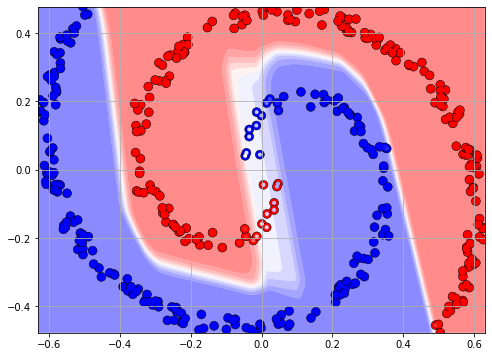

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

# Single Layer NN

In [32]:
actf = nn.LeakyReLU
# actf = nn.ELU
mlpNet = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                         nn.Sigmoid()
                        )
optimizer = torch.optim.Adam(mlpNet.parameters(), lr=0.01)
# criterion = nn.BCELoss()
criterion = BCE_MSE_Loss()

In [33]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(50000):
    yout = mlpNet(inp)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}')
        ax.clear()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.')
        
        yout_img = mlpNet(xx_img)
        # out = (yout_img.data.numpy()>0.5).astype(int)
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:139.86215209960938, Acc:50.0


Epoch: 100, Loss:1.306637167930603, Acc:100.0


Epoch: 200, Loss:0.11652390658855438, Acc:100.0


Epoch: 300, Loss:0.03529776632785797, Acc:100.0


Epoch: 400, Loss:0.017861410975456238, Acc:100.0


Epoch: 500, Loss:0.010873186402022839, Acc:100.0


Epoch: 600, Loss:0.007309837732464075, Acc:100.0


Epoch: 700, Loss:0.005267717409878969, Acc:100.0


Epoch: 800, Loss:0.003978582099080086, Acc:100.0


Epoch: 900, Loss:0.0031110821291804314, Acc:100.0


Epoch: 1000, Loss:0.002502660034224391, Acc:100.0


Epoch: 1100, Loss:0.0020601688884198666, Acc:100.0


Epoch: 1200, Loss:0.001726342597976327, Acc:100.0


Epoch: 1300, Loss:0.0014688227092847228, Acc:100.0


Epoch: 1400, Loss:0.0012651856523007154, Acc:100.0


Epoch: 1500, Loss:0.0010999154765158892, Acc:100.0


Epoch: 1600, Loss:0.0009642193326726556, Acc:100.0


Epoch: 1700, Loss:0.0008513216162100434, Acc:100.0


Epoch: 1800, Loss:0.0007565395790152252, Acc:100.0


Epoch: 1900, Loss:0.0006

TclError: invalid command name "pyimage63"

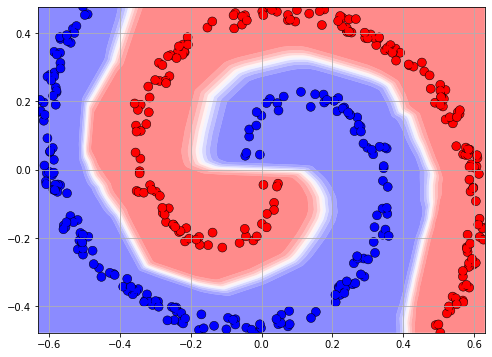

In [34]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

# Multiple Invex 

## Freeze initial invex func

In [103]:
class LipschitzInvexNet(nn.Module):
    
    def __init__(self, net_invx, net_lips, lamda=1.):
        super().__init__()
        
        self.net_lips = net_lips
        self.net_invx = net_invx
        self.lamda = lamda
        
        self.X = None
        self.Y_lips = None
        self.Y_invx = None
        self.Y = None

        self.dydx_invx = None
        self.dydx_lips = None
        self.dydx = None
        
        self.gp = 0
        self.gclipper = 999
        
        self._temp_hook_invx = False
        
    def forward(self, x, hook_invx=False, hook_lips=True):
#         self.weight_norm()
        self.X = x
        if not self.X.requires_grad:
            self.X = torch.autograd.Variable(x, requires_grad=True)
                    
#         with torch.no_grad():
        self.Y_invx = self.net_invx(self.X, hook_invx)
        self._temp_hook_invx = hook_invx
    
        self.Y_lips = self.net_lips(self.X)
        y = self.Y_lips+0.
        if hook_lips:
            y.register_hook(self.scale_gradient_back)

        self.Y = self.Y_invx+y
        return self.Y
        
    def get_dydx_invx(self):
        self.dydx_invx = self.net_invx.dydx.data
        return self.dydx_invx
    
    def get_dydx_lips(self):
        self.dydx_lips = torch.autograd.grad(outputs=self.Y_lips, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y_lips),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx_lips
    
#     def get_dydx(self):
#         self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
#                                     grad_outputs=torch.ones_like(self.Y),
#                                     only_inputs=True, retain_graph=True, create_graph=True)[0]
#         return self.dydx
    
    def scale_gradient_back(self, grad):
        if self._temp_hook_invx:
            violation = self.net_invx.cond <= 0
            self.gclipper[violation] = torch.zeros_like(self.gclipper)[violation]
#             grad = torch.minimum(torch.maximum(grad, -self.net_invx.gclipper), self.net_invx.gclipper)
        return torch.minimum(torch.maximum(grad, -self.gclipper), self.gclipper)
    
    def weight_norm(self):
        for child in get_children(self.net_lips):
            if isinstance(child, nn.Linear):
                norm = torch.norm(child.weight.data, dim=1)
                indx = torch.nonzero(norm>5., as_tuple=False).t()[0]
                if len(indx)==0: continue
                child.weight.data[indx] *= 3/(norm[indx].reshape(-1,1))
    
    def smooth_l1(self, x, beta=1):
        mask = x<beta
        y = torch.empty_like(x)
        y[mask] = 0.5*(x[mask]**2)/beta
        y[~mask] = torch.abs(x[~mask])-0.5*beta
        return y
    
    def get_gradient_penalty(self):
        norm_dydx_invx = torch.sqrt((self.dydx_invx**2).sum(dim=1, keepdim=True))
        m = self.dydx_lips.shape[0]
        dots = torch.bmm(self.dydx_lips.view(m, 1, -1), self.dydx_invx.view(m, -1, 1)).view(-1, 1)
        norm_proj = dots/norm_dydx_invx
        self.cond = (norm_proj+norm_dydx_invx)

#         norm_proj = dots/(norm_dydx_invx**2)
#         self.cond = (norm_proj+1)

        
#         intolerables = torch.clamp(F.softplus(self.cond-0.1, beta=-20), -1, 1)
        intolerables = F.softplus(self.cond-0.1, beta=-20)
        self.gp = (self.smooth_l1(intolerables*5)).mean()*self.lamda
        return self.gp
    
    def get_gradient_clipper(self):
        with torch.no_grad():
            cond = self.cond.data
            linear_mask = cond>0.14845
            a = 20.
            gclipper = -((1.05*(cond-1))**4)+1
            gclipper = torch.log(torch.exp(a*gclipper)+1)/a
            gc2 = 3*cond-0.0844560006
            gclipper[linear_mask] = gc2[linear_mask]
            self.gclipper = gclipper
        return self.gclipper

    def compute_penalty_and_clipper(self):
        self.get_dydx_lips()
        self.get_dydx_invx()
        self.dydx = self.dydx_invx+self.dydx_lips
        
        self.get_gradient_penalty()
        self.get_gradient_clipper()
        return

In [104]:
actf = nn.LeakyReLU
# actf = nn.ELU # nn.Softplus

net_invx = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
#                          nn.Sigmoid()
                        )
lcNet = BasicInvexNet(2, net_invx, lamda=2)

net_lips = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
sigmoid = nn.Sigmoid()
# sigmoid = lambda x:x

liNet = LipschitzInvexNet(lcNet, net_lips, lamda=2)

optimizer = torch.optim.Adam(lcNet.parameters(), lr=0.0051)
criterion = nn.BCELoss()
# criterion = BCE_MSE_Loss()

In [106]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(5000):
    yout = sigmoid(lcNet(inp))    
    lcNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + lcNet.gp

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(lcNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(lcNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.07966353744268417, Acc:95.0, MinVal:-0.18983078002929688, gp: 0.0065818349830806255


Epoch: 100, Loss:0.09698005020618439, Acc:93.25, MinVal:0.7839107513427734, gp: 2.9067198193518317e-16


Epoch: 200, Loss:0.09722355008125305, Acc:93.75, MinVal:2.582503318786621, gp: 0.0


Epoch: 300, Loss:0.07993178069591522, Acc:94.25, MinVal:0.1766490936279297, gp: 5.970515303488355e-06


TclError: invalid command name "pyimage380"

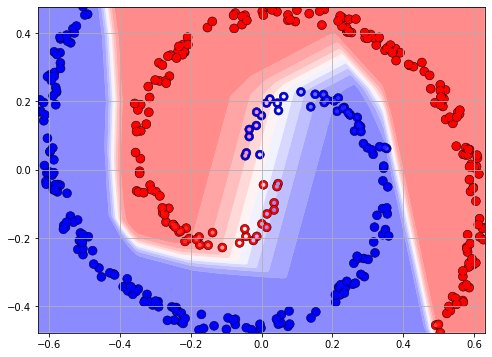

In [107]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

In [108]:
optimizer = torch.optim.Adam(net_lips.parameters(), lr=0.0051)

In [130]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(50000):
    yout = sigmoid(liNet(inp))
    #lcNet.compute_penalty_and_clipper()
    lcNet.get_dydx()
    
    liNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + liNet.gp #+ lcNet.gp

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(liNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(liNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(liNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.0071695102378726006, Acc:100.0, MinVal:19.984214782714844, gp: 0.0


Epoch: 100, Loss:0.0022317867260426283, Acc:100.0, MinVal:4.962033748626709, gp: 0.0


Epoch: 200, Loss:0.01049791555851698, Acc:99.75, MinVal:3.088714599609375, gp: 0.0


Epoch: 300, Loss:0.004921933636069298, Acc:100.0, MinVal:7.6936187744140625, gp: 0.0


TclError: invalid command name "pyimage510"

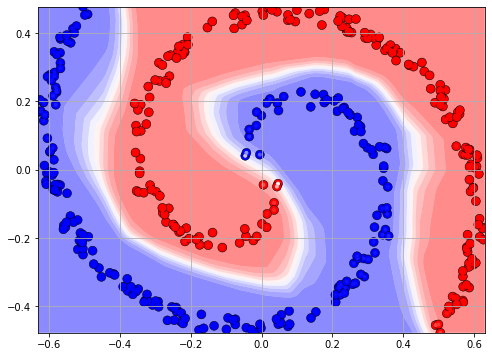

In [119]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

## Mixup Training

In [113]:
actf = nn.LeakyReLU
# actf = nn.ELU # nn.Softplus

net_invx = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
#                          nn.Sigmoid()
                        )
lcNet = BasicInvexNet(2, net_invx, lamda=2)

net_lips = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
net_lips[-1].weight.data *= 0.
net_lips[-1].bias.data *= 0.

sigmoid = nn.Sigmoid()
# sigmoid = lambda x:x

liNet = LipschitzInvexNet(lcNet, net_lips, lamda=2)

optimizer = torch.optim.Adam(lcNet.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [114]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(5000):
    rand_indx = np.random.permutation(len(inp))
    
    rand_lambda = torch.rand(len(inp), 1)*0.1
    
    
    x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
    y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    
    yout = sigmoid(lcNet(x_mix))    
    lcNet.compute_penalty_and_clipper()
    loss = criterion(yout, y_mix) + lcNet.gp

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
   
    if epoch%100 == 0:
        yout = sigmoid(lcNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(lcNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(lcNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
#         yout = sigmoid(lcNet(inp))
        x1_, x2_ = x_mix[:,0].data.numpy(), x_mix[:,1].data.numpy()
        ax.scatter(x1_, x2_, c=y_mix.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.9615657925605774, Acc:38.75, MinVal:-0.08111867308616638, gp: 0.2657814025878906


Epoch: 100, Loss:0.42111268639564514, Acc:80.75, MinVal:0.1494131088256836, gp: 1.7616703189560212e-05


Epoch: 200, Loss:0.33202964067459106, Acc:81.25, MinVal:0.22096490859985352, gp: 1.1693491615005769e-06


Epoch: 300, Loss:0.2495717853307724, Acc:89.5, MinVal:0.1569826602935791, gp: 1.2042969501635525e-05


Epoch: 400, Loss:0.24495728313922882, Acc:91.0, MinVal:-0.14798569679260254, gp: 0.006658241152763367


Epoch: 500, Loss:0.2135806530714035, Acc:95.75, MinVal:0.18474316596984863, gp: 7.047016879369039e-06


Epoch: 600, Loss:0.22322328388690948, Acc:96.0, MinVal:0.6072263717651367, gp: 5.591394860136878e-13


Epoch: 700, Loss:0.21519386768341064, Acc:96.25, MinVal:0.03630709648132324, gp: 0.0005217153811827302


Epoch: 800, Loss:0.2110607773065567, Acc:96.25, MinVal:0.04923677444458008, gp: 0.00028951987042091787


Epoch: 900, Loss:0.19472908973693848, Acc:96.0, MinVal:-0.0042200

TclError: invalid command name "pyimage410"

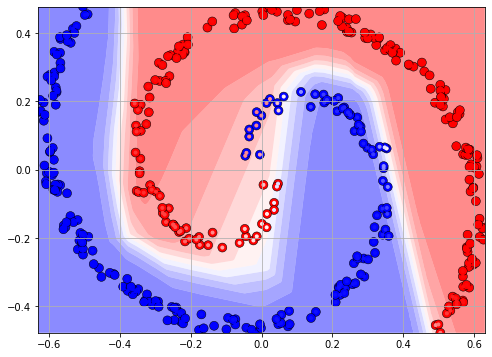

In [115]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
yout = sigmoid(lcNet(inp))
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

In [116]:
# net_lips = nn.Sequential(nn.Linear(2,100),
#                          actf(),
#                          nn.Linear(100,100),
#                          actf(),
#                          nn.Linear(100,1),
#                         )
# # net_lips[-1].weight.data *= 0.
# # net_lips[-1].bias.data *= 0.
# liNet = LipschitzInvexNet(lcNet, net_lips, lamda=2)

optimizer = torch.optim.Adam(net_lips.parameters(), lr=0.0051)

In [120]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(50000):
    rand_indx = np.random.permutation(len(inp))
    rand_lambda = torch.rand(len(inp), 1)*0.1
    x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
    y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    
    yout = sigmoid(liNet(x_mix))    
    lcNet.get_dydx()
    liNet.compute_penalty_and_clipper()
    loss = criterion(yout, y_mix) + liNet.gp #+ lcNet.gp

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
   
    if epoch%100 == 0:
        yout = sigmoid(liNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(liNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(liNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(liNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        x1_, x2_ = x_mix[:,0].data.numpy(), x_mix[:,1].data.numpy()
        ax.scatter(x1_, x2_, c=y_mix.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.13976162672042847, Acc:100.0, MinVal:0.1850142478942871, gp: 1.2957798389834352e-05


Epoch: 100, Loss:0.14063513278961182, Acc:98.25, MinVal:2.2946860790252686, gp: 1.6899659479757294e-42


Epoch: 200, Loss:0.1562548726797104, Acc:99.0, MinVal:1.8649828433990479, gp: 6.822734516065641e-35


Epoch: 300, Loss:0.14127545058727264, Acc:99.0, MinVal:1.4436142444610596, gp: 7.131604472716729e-28


Epoch: 400, Loss:0.1416398286819458, Acc:99.0, MinVal:2.1463804244995117, gp: 8.202164249293879e-40


Epoch: 500, Loss:0.14457888901233673, Acc:99.0, MinVal:1.1337203979492188, gp: 1.729528688429817e-22


Epoch: 600, Loss:0.14270496368408203, Acc:99.0, MinVal:0.5238132476806641, gp: 6.783261018855624e-12


Epoch: 700, Loss:0.13003690540790558, Acc:99.0, MinVal:0.36304140090942383, gp: 2.932049980586271e-08


Epoch: 800, Loss:0.1278214454650879, Acc:98.75, MinVal:1.1749675273895264, gp: 3.3092184859493137e-23


Epoch: 900, Loss:0.14911319315433502, Acc:99.0, MinVal:0.34364604949951

TclError: invalid command name "."

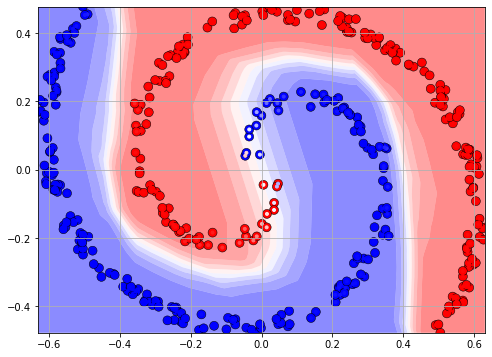

In [99]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
yout = sigmoid(liNet(inp))
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

## Inputs to check condition

In [121]:
actf = nn.LeakyReLU
# actf = nn.ELU # nn.Softplus

net_invx = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
#                          nn.Sigmoid()
                        )
lcNet = BasicInvexNet(2, net_invx, lamda=1)

net_lips = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
net_lips[-1].weight.data *= 0.
net_lips[-1].bias.data *= 0.

sigmoid = nn.Sigmoid()
# sigmoid = lambda x:x

liNet = LipschitzInvexNet(lcNet, net_lips, lamda=1)

optimizer = torch.optim.Adam(lcNet.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [122]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(5000):
    
    optimizer.zero_grad()

    yout = sigmoid(lcNet(inp))    
    lcNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + lcNet.gp

    loss.backward(retain_graph=True)    
    
    rand_inp = torch.rand(400*2, 2)*(inp.max(0,True)[0] - inp.min(0,True)[0])+inp.min(0,True)[0]
    lcNet(rand_inp)
    lcNet.compute_penalty_and_clipper()
    lcNet.gp.backward(retain_graph=True)
        
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(lcNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(lcNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.7997753024101257, Acc:50.0, MinVal:-0.07664797455072403, gp: 0.11222713440656662


Epoch: 100, Loss:0.39777469635009766, Acc:82.5, MinVal:-0.03618592023849487, gp: 0.002745961304754019


Epoch: 200, Loss:0.29634156823158264, Acc:85.0, MinVal:-0.21190065145492554, gp: 0.006867620162665844


Epoch: 300, Loss:0.17732374370098114, Acc:89.75, MinVal:0.35834813117980957, gp: 1.286015516299699e-09


Epoch: 400, Loss:0.13616374135017395, Acc:92.0, MinVal:0.11555910110473633, gp: 1.2367489944153931e-05


Epoch: 500, Loss:0.12380702048540115, Acc:93.25, MinVal:-0.24297428131103516, gp: 0.0018884929595515132


Epoch: 600, Loss:0.10746649652719498, Acc:94.0, MinVal:0.27170848846435547, gp: 6.856321022041811e-08


Epoch: 700, Loss:0.09804820269346237, Acc:94.25, MinVal:0.3755011558532715, gp: 6.510129657577579e-10


Epoch: 800, Loss:0.09769998490810394, Acc:94.0, MinVal:-0.02721405029296875, gp: 0.0004908086848445237


Epoch: 900, Loss:0.07733358442783356, Acc:94.75, MinVal:0.07023

TclError: invalid command name "."

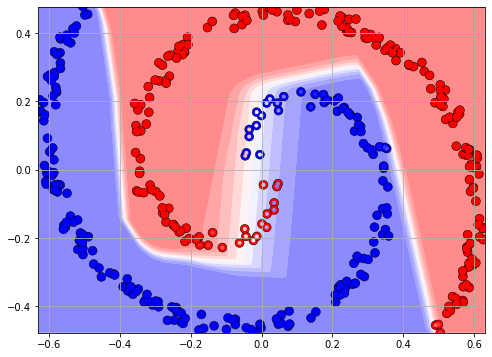

In [123]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

In [124]:
optimizer = torch.optim.Adam(net_lips.parameters(), lr=0.01)
# torch.min(inp, dim=0)[0]

In [131]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(50000):
    optimizer.zero_grad()
    
    yout = sigmoid(liNet(inp))
#     lcNet.compute_penalty_and_clipper()
    lcNet.get_dydx()
    liNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + liNet.gp #+ lcNet.gp
    loss.backward()

    rand_inp = torch.rand(400*4, 2)*(inp.max(0,True)[0] - inp.min(0,True)[0])+inp.min(0,True)[0]
    liNet(rand_inp)
    
    lcNet.get_dydx()
    liNet.compute_penalty_and_clipper()
    liNet.gp.backward()
        
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(liNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(liNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(liNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
#         ax.scatter(rand_inp[:,0].data.numpy(), rand_inp[:,1].data.numpy(),
#                    c=liNet.cond.data.numpy(), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.0048870206810534, Acc:100.0, MinVal:-9.718921661376953, gp: 0.7532128095626831


Epoch: 100, Loss:0.02053067274391651, Acc:99.5, MinVal:0.6638362407684326, gp: 6.264935198765399e-15


Epoch: 200, Loss:0.023111583665013313, Acc:99.5, MinVal:2.1292901039123535, gp: 2.184638318867033e-40


Epoch: 300, Loss:0.01811184547841549, Acc:99.75, MinVal:2.285543441772461, gp: 2.1019476964872256e-43


Epoch: 400, Loss:0.017484040930867195, Acc:100.0, MinVal:3.3459901809692383, gp: 0.0


Epoch: 500, Loss:0.016847999766469002, Acc:100.0, MinVal:1.595181941986084, gp: 2.0737643457263097e-31


Epoch: 600, Loss:0.01607637107372284, Acc:100.0, MinVal:1.464564323425293, gp: 3.8531845674643456e-29


TclError: invalid command name "."

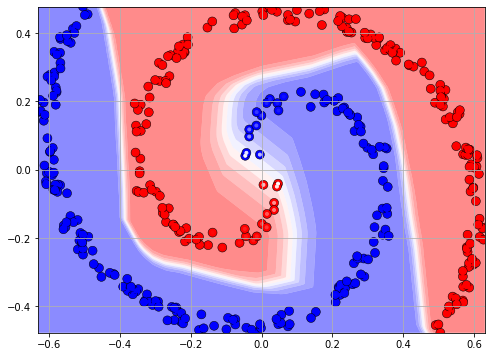

In [132]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

## Mixup + Penalty only Input

In [110]:
actf = nn.LeakyReLU
# actf = nn.ELU # nn.Softplus

net_invx = nn.Sequential(nn.Linear(2,20),
                         actf(),
                         nn.Linear(20,20),
                         actf(),
                         nn.Linear(20,20),
                         actf(),
                         nn.Linear(20,20),
                         actf(),
                         nn.Linear(20,1),
#                          nn.Sigmoid()
                        )
lcNet = BasicInvexNet(2, net_invx, lamda=2)

net_lips = nn.Sequential(nn.Linear(2,20),
                         actf(),
                         nn.Linear(20,20),
                         actf(),
                         nn.Linear(20,20),
                         actf(),
                         nn.Linear(20,20),
                         actf(),
                         nn.Linear(20,1),
                        )
sigmoid = nn.Sigmoid()
# sigmoid = lambda x:x

liNet = LipschitzInvexNet(lcNet, net_lips, lamda=2)

optimizer = torch.optim.Adam(lcNet.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [61]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(5000):
    optimizer.zero_grad()
    
    rand_indx = np.random.permutation(len(inp))
    rand_lambda = torch.rand(len(inp), 1)*0.1
    
    x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
    y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    
    yout = sigmoid(lcNet(x_mix))    
    lcNet.compute_penalty_and_clipper()
    loss = criterion(yout, y_mix) + lcNet.gp

    loss.backward(retain_graph=True)
    
    rand_inp = torch.rand(400*2, 2)*(inp.max(0,True)[0] - inp.min(0,True)[0])+inp.min(0,True)[0]
    lcNet(rand_inp)
    lcNet.compute_penalty_and_clipper()
    lcNet.gp.backward(retain_graph=True)
        
    optimizer.step()
   
    if epoch%100 == 0:
        yout = sigmoid(lcNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(lcNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(lcNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
#         yout = sigmoid(lcNet(inp))
        x1_, x2_ = x_mix[:,0].data.numpy(), x_mix[:,1].data.numpy()
        ax.scatter(x1_, x2_, c=y_mix.data.numpy().reshape(-1), marker='o', cmap=matplotlib.cm.bwr)
        
        ax.scatter(rand_inp[:,0].data.numpy(), rand_inp[:,1].data.numpy(),
                   c=lcNet.cond.data.numpy(), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.9998197555541992, Acc:50.0, MinVal:-0.04354552924633026, gp: 0.29629358649253845


Epoch: 100, Loss:0.43775516748428345, Acc:83.25, MinVal:-0.2788577079772949, gp: 0.007743437774479389


Epoch: 200, Loss:0.4296286702156067, Acc:82.5, MinVal:-0.009316444396972656, gp: 0.0019330934155732393


Epoch: 300, Loss:0.36080363392829895, Acc:86.75, MinVal:0.08548427373170853, gp: 0.000753847707528621


Epoch: 400, Loss:0.2539936900138855, Acc:92.75, MinVal:0.11465567350387573, gp: 4.459517003851943e-05


Epoch: 500, Loss:0.23026488721370697, Acc:92.75, MinVal:0.3863821029663086, gp: 1.077788414072245e-09


Epoch: 600, Loss:0.2954603135585785, Acc:87.75, MinVal:0.7036139965057373, gp: 6.242828062358536e-15


Epoch: 700, Loss:0.21156547963619232, Acc:93.0, MinVal:-0.02409982681274414, gp: 0.0005594549002125859


Epoch: 800, Loss:0.2031339854001999, Acc:93.5, MinVal:0.23982620239257812, gp: 4.303816467654542e-07


Epoch: 900, Loss:0.19560343027114868, Acc:93.5, MinVal:-0.1001269817

TclError: invalid command name "."

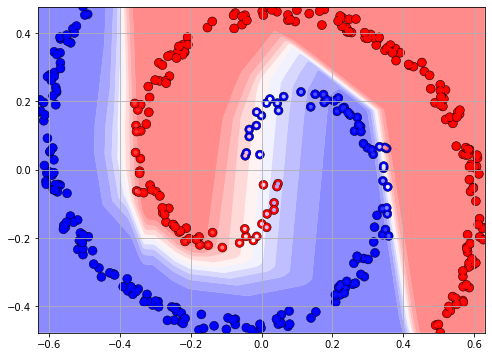

In [62]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
yout = sigmoid(lcNet(inp))
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

In [63]:
optimizer = torch.optim.Adam(net_lips.parameters(), lr=0.01)

In [64]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(50000):
    optimizer.zero_grad()

    rand_indx = np.random.permutation(len(inp))
    rand_lambda = torch.rand(len(inp), 1)*0.01
    x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
    y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    
    yout = sigmoid(liNet(x_mix))    
    lcNet.get_dydx()
#     lcNet.compute_penalty_and_clipper()
    liNet.compute_penalty_and_clipper()
    loss = criterion(yout, y_mix) + liNet.gp #+ lcNet.gp
    loss.backward(retain_graph=True)
    
    rand_inp = torch.rand(400*4, 2)*(inp.max(0,True)[0] - inp.min(0,True)[0])+inp.min(0,True)[0]
    liNet(rand_inp)
    
    lcNet.get_dydx()
#     lcNet.compute_penalty_and_clipper()
    liNet.compute_penalty_and_clipper()
    liNet.gp.backward(retain_graph=True)
    
    optimizer.step()
   
    if epoch%100 == 0:
        yout = sigmoid(liNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(liNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(liNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(liNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        x1_, x2_ = x_mix[:,0].data.numpy(), x_mix[:,1].data.numpy()
        ax.scatter(x1_, x2_, c=y_mix.data.numpy().reshape(-1), marker='o', cmap=matplotlib.cm.bwr)
        
        ax.scatter(rand_inp[:,0].data.numpy(), rand_inp[:,1].data.numpy(),
                   c=liNet.cond.data.numpy(), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.693260669708252, Acc:50.0, MinVal:0.9490408301353455, gp: 1.4194455707356907e-17


Epoch: 100, Loss:0.361740380525589, Acc:84.25, MinVal:0.1174975037574768, gp: 3.334203574922867e-05


Epoch: 200, Loss:0.32677990198135376, Acc:83.5, MinVal:0.18689757585525513, gp: 1.2661737855523825e-05


Epoch: 300, Loss:0.27554255723953247, Acc:84.75, MinVal:0.09852731227874756, gp: 0.0001968035358004272


Epoch: 400, Loss:0.2985544502735138, Acc:85.25, MinVal:0.06548911333084106, gp: 0.0006551067344844341


Epoch: 500, Loss:0.24957579374313354, Acc:86.0, MinVal:-0.39796125888824463, gp: 0.005368541926145554


Epoch: 600, Loss:0.2953573167324066, Acc:84.75, MinVal:0.07271349430084229, gp: 0.00024454458616673946


Epoch: 700, Loss:0.3878844380378723, Acc:81.75, MinVal:0.6052908897399902, gp: 5.911468688689359e-13


Epoch: 800, Loss:0.27999863028526306, Acc:84.0, MinVal:-0.037248969078063965, gp: 0.00030971254454925656


Epoch: 900, Loss:0.27756351232528687, Acc:84.0, MinVal:-0.1318566

TclError: invalid command name "."

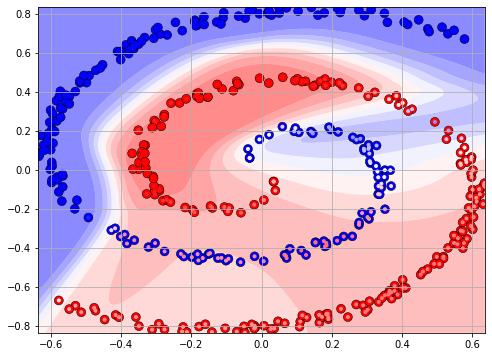

In [743]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
yout = sigmoid(liNet(inp))
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

### No freezing previous invex

In [111]:
optimizer = torch.optim.Adam(liNet.parameters(), lr=0.005)

In [112]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(50000):
    optimizer.zero_grad()

    rand_indx = np.random.permutation(len(inp))
    rand_lambda = torch.rand(len(inp), 1)*0.01
    x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
    y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    
    yout = sigmoid(liNet(x_mix, True))    
#     lcNet.get_dydx()
    lcNet.compute_penalty_and_clipper()
    liNet.compute_penalty_and_clipper()
    loss = criterion(yout, y_mix) 
    loss += liNet.gp 
    loss += lcNet.gp
    loss.backward(retain_graph=True)
    
    rand_inp = torch.rand(400*4, 2)*(inp.max(0,True)[0] - inp.min(0,True)[0])+inp.min(0,True)[0]
    liNet(rand_inp, True)
    
#     lcNet.get_dydx()
    lcNet.compute_penalty_and_clipper()
    liNet.compute_penalty_and_clipper()
    (lcNet.gp+liNet.gp).backward(retain_graph=True)
    
    optimizer.step()
   
    if epoch%100 == 0:
        yout = sigmoid(liNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(liNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(liNet.gp)}')
        print(f'InvxNet; MinVal:{lcNet.cond.min()}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(liNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        x1_, x2_ = x_mix[:,0].data.numpy(), x_mix[:,1].data.numpy()
        ax.scatter(x1_, x2_, c=y_mix.data.numpy().reshape(-1), marker='o', cmap=matplotlib.cm.bwr)
        
        ax.scatter(rand_inp[:,0].data.numpy(), rand_inp[:,1].data.numpy(),
                   c=liNet.cond.data.numpy(), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:1.3937400579452515, Acc:50.0, MinVal:-0.08610733598470688, gp: 0.3848627805709839
InvxNet; MinVal:-0.01419124286621809, gp: 0.2887647747993469


Epoch: 100, Loss:0.5018820762634277, Acc:72.0, MinVal:0.043495915830135345, gp: 0.0003375322266947478
InvxNet; MinVal:-0.17164717614650726, gp: 0.00799509882926941


Epoch: 200, Loss:0.2608901560306549, Acc:88.75, MinVal:1.0669949054718018, gp: 3.1260649766477767e-21
InvxNet; MinVal:-0.0031476058065891266, gp: 0.001415447099134326


Epoch: 300, Loss:0.24901480972766876, Acc:89.0, MinVal:0.1438225507736206, gp: 4.999023076379672e-06
InvxNet; MinVal:-0.1638396978378296, gp: 0.007878337986767292


Epoch: 400, Loss:0.266694575548172, Acc:86.75, MinVal:0.769643247127533, gp: 1.118851219863244e-15
InvxNet; MinVal:0.45160311460494995, gp: 3.65541277802528e-11


Epoch: 500, Loss:0.2187841683626175, Acc:89.25, MinVal:0.13307392597198486, gp: 4.214905129629187e-05
InvxNet; MinVal:0.15954938530921936, gp: 0.00018441729480400681


Epoch: 60

TclError: invalid command name "."

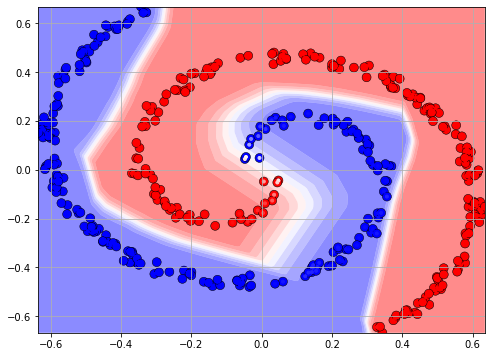

In [926]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
yout = sigmoid(liNet(inp))
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

In [927]:
yy_img_ = liNet(xx_img)

In [942]:
yy_img__ = sigmoid(yy_img_.data/5)

In [943]:
# xx_img.shape, yy_img.shape

In [944]:
%matplotlib tk
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')
# ax = fig.gca(projection='3d')

ax.plot_surface(x_, y_, yy_img__.data.numpy().reshape(200,200), cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

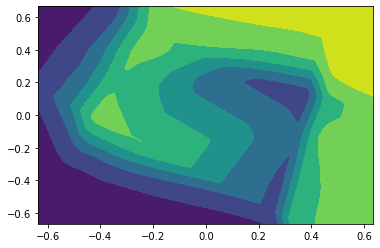

In [945]:
%matplotlib inline
plt.contourf(x_, y_, yy_img__.data.numpy().reshape(200,200))